### Look at first run results

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.grid import region_mask, single_cavity_mask, calc_geometry
from nemo_python_git.constants import region_names, deg_string, gkg_string, region_points
from nemo_python_git.plots import timeseries_by_region
import imageio
import glob
import matplotlib.path as mpath
import cmocean

In [2]:
# To make circular maps:
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

In [3]:
def prepare_plot(figsize=(15, 8)):
    """This function returns prepared axes for the polar plot.
    
    Usage:
        fig, ax = prepare_plot()
    """
    fig, ax = plt.subplots(1,2, figsize=figsize, subplot_kw={'projection': ccrs.SouthPolarStereo()})
    for axis in ax.ravel():
        axis.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        axis.set_boundary(map_circle, transform=axis.transAxes)
        # ax.coastlines(); 
        gl = axis.gridlines(draw_labels=True, ylocs=[]);#, color='w', lw=2);
    return fig, ax

In [3]:
# tmask = np.ma.masked_where(mesh.tmask.values==0, mesh.tmask.values)

In [ ]:
def plot_2D_circumpolar(fileT, month, depth, path='.', save=True, Tmin=-4, Tmax=4):

    kwags1  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.balance, 'rasterized':True, 'vmin':Tmin, 'vmax':Tmax}
    kwags2  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.haline, 'rasterized':True, 'vmin':33, 'vmax':35.5}
    fig, ax = prepare_plot()
    cm1 = ax[0].pcolormesh(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, fileT.thetao.isel(time_counter=month-1, deptht=depth), **kwags1)
    ax[0].add_feature(cfeature.LAND, color='w', zorder=3)
    cm2 = ax[1].pcolormesh(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, fileT.so.isel(time_counter=month-1, deptht=depth), **kwags2)
    ax[1].add_feature(cfeature.LAND, color='w', zorder=3)
    CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.04)
    CB1.set_label(fileT.thetao.long_name)
    CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.04)
    CB2.set_label(fileT.so.long_name)

    date = fileT.time_counter.isel(time_counter=month-1).dt.strftime('%Y-%m').values
    year = str(date)[:-3]
    fig.suptitle(f"{str(date)}, depth: {mesh.nav_lev.values[depth]:.1f} m")
    
    if save:
        fig.savefig(f'{path}circumpolar_y{year}m{month:02}z{depth:03}.jpg', bbox_inches='tight')

    plt.close(fig)
    
    return

In [ ]:
def create_animation(filenames, out_file='test.mp4'):
    
    # filenames is a list of the names/locations of image files to combine into animation (mp4 in this case)
    with imageio.get_writer(f'{out_file}', fps=2, mode='I') as writer: 
        for filename in filenames:  
            image = imageio.imread(filename)  
            writer.append_data(image)
    return

In [ ]:
def amundsen_frame(fileT_ini, var, month, path):
    depth_ind = [0, 18, 35]
    fileT    = fileT_ini.isel(x_grid_T=slice(500, 900), y_grid_T=slice(150,350))
    mesh_sub = mesh.isel(x=slice(500, 900), y=slice(150,350))
    
    # --------- figure -------------------------------------------------------------
    fig  = plt.figure(figsize=(18,8))
    date = fileT_ini.time_counter.isel(time_counter=month-1).dt.strftime('%Y-%m').values
    fig.suptitle(f"{str(date)}")
    gs = fig.add_gridspec(3,5)
    
    ax1 = fig.add_subplot(gs[0, 0:3], projection=ccrs.Mercator(latitude_true_scale=-70))
    ax2 = fig.add_subplot(gs[1, 0:3], projection=ccrs.Mercator(latitude_true_scale=-70))
    ax3 = fig.add_subplot(gs[2, 0:3], projection=ccrs.Mercator(latitude_true_scale=-70))
    ax4 = fig.add_subplot(gs[:, 3]) # temperature
    ax5 = fig.add_subplot(gs[:, 4]) # salinity
    
    vm = [(-2.5, 2.5),(-2.5,2.5),(-2.5,2.5)] # colorbar limits
    # vm = [(31, 34.5),(31,34.5),(34.4,35)] # colorbar limits
    # Coordinates of 'stations'
    i1, i2 = (249, 715) # on Amundsen shelf
    s1, s2 = (271, 711) # Amundsen shelf break
    o1, o2 = (281, 711) # off Amundsen slope
    lon    = mesh.nav_lon.values
    lat    = mesh.nav_lat.values
    
    # --- Maps ---
    kwags1  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.balance, 'rasterized':True}
    for i, axis in enumerate([ax1, ax2, ax3]):
        axis.set_extent([-80, -140, -75.5, -68], ccrs.PlateCarree())
        axis.set_title(f'{fileT[var].long_name}, depth: {mesh.nav_lev.values[depth_ind[i]]:.1f} m')
        lon_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=depth_ind[i]) == 0, fileT.nav_lon_grid_T.values)
        lat_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=depth_ind[i]) == 0, fileT.nav_lat_grid_T.values)
        plot_var = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=depth_ind[i]) == 0, fileT[var].isel(time_counter=month-1, deptht=depth_ind[i]).values)
        cm = axis.pcolormesh(lon_plot, lat_plot, plot_var, vmin=vm[i][0], vmax=vm[i][1], **kwags1)
    
        # mark shelf break with dashed line
        axis.contour(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, mesh_sub.bathy_metry, [1200], 
                     linestyles='--', linewidths=0.8, colors='k', transform=ccrs.PlateCarree(), zorder=3)
    
        stn_kwags = {'transform':ccrs.PlateCarree(), 'marker':'*', 's':90, 'zorder':3, 'edgecolors':'k', 'linewidths':0.6}
        axis.scatter([lon[i1,i2], lon[i1,i2]], [lat[i1,i2], lat[i1,i2]], **stn_kwags)
        axis.scatter([lon[s1,s2], lon[s1,s2]], [lat[s1,s2], lat[s1,s2]], **stn_kwags)
        axis.scatter([lon[o1,o2], lon[o1,o2]], [lat[o1,o2], lat[o1,o2]], **stn_kwags)
        CB1 = fig.colorbar(cm, ax=axis, fraction=0.04)

        gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False; gl.right_labels = False;
        gl.xlines = False; gl.ylines = False;
        
    # --- profiles ---
    ax4.set_xlim(-2.5, 2.5)
    ax5.set_xlim(32.5, 35)
    vars = ['thetao', 'so']
    for i, axis in enumerate([ax4, ax5]):
        axis.invert_yaxis()
        axis.set_ylim(600, 0)
        plot1 = xr.where(fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=i1, x_grid_T=i2) == 0, np.nan, 
                         fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=i1, x_grid_T=i2))
        plot2 = xr.where(fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=s1, x_grid_T=s2) == 0, np.nan, 
                         fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=s1, x_grid_T=s2))
        plot3 = xr.where(fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=o1, x_grid_T=o2) == 0, np.nan, 
                         fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=o1, x_grid_T=o2))
        axis.set_title(fileT_ini[vars[i]].long_name)
        axis.plot(plot1, mesh.nav_lev, label='Shelf')
        axis.plot(plot2, mesh.nav_lev, label='Shelf break')
        axis.plot(plot3, mesh.nav_lev, label='Open ocean')
        
        for di in depth_ind:
            axis.plot([-10, 40],[mesh.nav_lev.values[di], mesh.nav_lev.values[di]], '--k')
        axis.set_ylabel('Depth (m)')
        axis.legend(frameon=False, loc=(0.1, 0.05), fontsize=12)
    
    fig.tight_layout()
    fig.savefig(f'{path}amundsen_y{str(date)[:-3]}m{month:02}.jpg', bbox_inches='tight')
    plt.close(fig)
    return

In [ ]:
run_path  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/'
for year in range(1979,1984):
    fileT = xr.open_dataset(run_path + f'eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc')
    for month in range(1,13):
        amundsen_frame(fileT, 'thetao', month, run_path+'temp/')

filenames=glob.glob(f'{run_path}temp/amundsen_y????m??.jpg')

create_animation(filenames, out_file=f'{run_path}amundsen-thetao.mp4')

In [ ]:
run_path = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/'

# for year in range(1979,1984):
#     fileT = xr.open_dataset(run_path + f'eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc')
#     for depth in [0, 20, 50, 80, 100]:
#         for month in range(1,13):
#             plot_2D_circumpolar(fileT, month, depth, path=run_path+'temp/')

for depth in [0, 20, 50, 80, 100]:
    filenames=glob.glob(f'{run_path}temp/circumpolar_y????m??z{depth:03}.jpg')        
    create_animation(filenames, out_file=f'{run_path}circumpolar_monthly_z{depth:03}.mp4')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(18,10), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

for axis in ax.ravel():
    axis.set_extent([-90, -160, -78, -64], ccrs.PlateCarree())
    cs = axis.contour(SOSE_sal_jan.XC, SOSE_sal_jan.YC, SOSE_sal_jan.Depth, levels=[1000, 2000], 
                      colors='w', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
    
cm1 = ax[0,0].pcolormesh(WOA_sal.lon, WOA_sal.lat, WOA_sal.s_an.isel(time=0), 
                             transform=ccrs.PlateCarree(), vmin=31, vmax=34)
# CB1 = fig.colorbar(cm1, ax=ax[0,0], fraction=0.03, label='Sea water salinity at standard depths (g/kg)')

Check drift in near-bottom temperature and salinity by region:

In [2]:
nemo_mesh = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240201.nc')

In [3]:
def calc_timeseries(var, ds_nemo, domain_cfg='/gws/nopw/j04/terrafirma/kaight/input_data/grids/domcfg_eORCA1v2.2x.nc', halo=True):

    nemo_mesh = xr.open_dataset(domain_cfg)
    
    # Parse variable name
    factor = 1
    region_type = None
    region = None
    if var.endswith('_bwtemp'):
        option = 'area_avg'
        region = var[:var.index('_bwtemp')]
        nemo_var = 'tob'
        units = deg_string+'C'
        title = 'Bottom temperature'
    elif var.endswith('_bwsalt'):
        option = 'area_avg'
        region = var[:var.index('_bwsalt')]
        nemo_var = 'sob'
        units = gkg_string
        title = 'Bottom salinity'

    # Select region
    if region is not None:
        if region_type is None:
            if region.endswith('cavity'):
                region = region[:region.index('_cavity')]
                region_type = 'cavity'
            elif region.endswith('shelf'):
                region = region[:region.index('_shelf')]
                region_type = 'shelf'
            else:
                region_type = 'all'
        if region in region_points and region_type == 'cavity':
            # Single ice shelf
            mask, _, region_name = single_cavity_mask(region, nemo_mesh, return_name=True)
        else:
            mask, _, region_name = region_mask(region, nemo_mesh, option=region_type, return_name=True)
        title += ' for '+region_name    
        
    if option == 'area_int':
        # Area integral
        dA = ds_nemo['area']*mask
        data = (ds_nemo[nemo_var]*dA).sum(dim=['x','y'])
    elif option == 'area_avg':
        # Area average
        dA = ds_nemo['area']*mask
        if nemo_var == 'draft':
            data_xy = calc_geometry(ds_nemo, keep_time_dim=True)[1]
        else:
            data_xy = ds_nemo[nemo_var]
        data = (data_xy*dA).sum(dim=['x','y'])/dA.sum(dim=['x','y'])
        
    data *= factor
    data = data.assign_attrs(long_name=title, units=units)

    return data, ds_nemo

In [68]:
run_folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/'

ts_bwtemp = {}; ts_bwsalt = {};
for year in range(1979, 1985):
    print(year)
    with xr.open_dataset(f'{run_folder}eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc') as file:
        # Need to rename some of the variables to work with the calc_timeseries function, and compress
        file      = file.rename({'sbt':'tob', 'sbs':'sob'})
        file_comp = file.get(['time_centered', 'time_counter', 'deptht','tob', 'sob'])
        file_comp['sob']  = ('time_counter', 'y', 'x'), file_comp['sob'].values
        file_comp['tob']  = ('time_counter', 'y', 'x'), file_comp['tob'].values
        file_comp['area'] = ('y', 'x'), file['area_grid_T'].values

        for name in ['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross', 'amery', 'all']: 
            ts_bwt, _ = calc_timeseries(f'{name}_bwtemp', file_comp, 
                                              domain_cfg='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240201.nc', halo=False)
            ts_bws, _ = calc_timeseries(f'{name}_bwsalt', file_comp, 
                                              domain_cfg='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240201.nc', halo=False)

            if year==1979:
                ts_bwtemp[name] = ts_bwt        
                ts_bwsalt[name] = ts_bws
            else:
                ts_bwtemp[name] = xr.concat([ts_bwtemp[name], ts_bwt], dim='time_counter')
                ts_bwsalt[name] = xr.concat([ts_bwsalt[name], ts_bws], dim='time_counter')

1979


In [5]:
colors = ['#00CB98','#059fdc','#ffd200','#f28800','#e34e59','#5b5496','k']

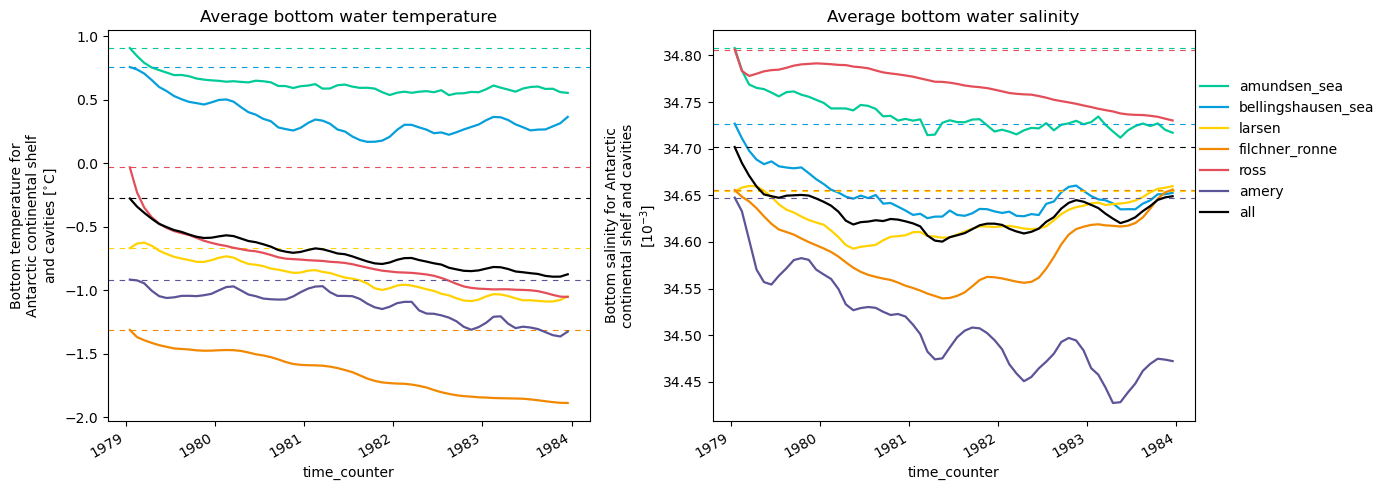

In [63]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

for i, name in enumerate(['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross','amery','all']):
    ax[0].axhline(y=ts_bwtemp[name].isel(time_counter=0).values, linestyle='--', color=colors[i], linewidth=0.8, dashes=(5, 5))
    ts_bwtemp[name].plot(ax=ax[0], label=name, color=colors[i], linewidth=1.6)
    ax[1].axhline(y=ts_bwsalt[name].isel(time_counter=0).values, linestyle='--', color=colors[i], linewidth=0.8, dashes=(5, 5))
    ts_bwsalt[name].plot(ax=ax[1], label=name, color=colors[i], linewidth=1.6)
    
ax[0].set_title('Average bottom water temperature')
ax[1].set_title('Average bottom water salinity')
ax[1].legend(frameon=False, loc=(1.0, 0.5))
fig.tight_layout()
# ax[1].plot(ts_amundsen_bwalt)

Also look at:
- SSH drift in full domain
- T, S thermocline drift

In [ ]:
file_comp['thetao']*mask*file_comp['area']).sum(dim=['x','y'])/((mask*file_comp['area']).sum(dim=['x','y'])

In [4]:
run_folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/'
year=1979
file = xr.open_dataset(f'{run_folder}eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc')

In [4]:
ant_regions = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/regions.nc')

In [ ]:
run_folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/'

ts_temp = {}; ts_salt = {};
for year in range(1979, 1980):
    print(year)
    with xr.open_dataset(f'{run_folder}eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc') as file:
        # Need to rename some of the variables to work with the calc_timeseries function, and compress
        file_comp = file.get(['time_centered', 'time_counter', 'deptht'])
        file_comp = file_comp.assign(so     = (('time_counter', 'deptht', 'y', 'x'), file['so'].values))
        file_comp = file_comp.assign(thetao = (('time_counter', 'deptht', 'y', 'x'), file['thetao'].values))
        file_comp['area']    = ('y', 'x'), file['area_grid_T'].values

        for name in ['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross', 'amery', 'all']: 
            T_profile = (file_comp['thetao']*ant_regions[f'mask_{name}']*file_comp['area']).sum(dim=['x','y'])/((ant_regions[f'mask_{name}']*file_comp['area']).sum(dim=['x','y']))
            S_profile = (file_comp['so']*ant_regions[f'mask_{name}']*file_comp['area']).sum(dim=['x','y'])/((ant_regions[f'mask_{name}']*file_comp['area']).sum(dim=['x','y']))
            
            if year==1979:
                ts_temp[name] = T_profile      
                ts_salt[name] = S_profile
            else:
                ts_temp[name] = xr.concat([ts_temp[name], T_profile], dim='time_counter')
                # ts_salt[name] = xr.concat([ts_salt[name], S_profile], dim='time_counter')

1979


In [39]:
masks={}
for name in ['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross', 'amery', 'all']: 
    mask, _, region_name = region_mask(name, nemo_mesh, option='all', return_name=True) ## this step uses a lot of memory
    masks[name] = mask

ds = xr.Dataset(
    data_vars={'mask_amundsen_sea'      :(["y","x"], masks['amundsen_sea'].values), 
               'mask_bellingshausen_sea':(["y","x"], masks['bellingshausen_sea'].values), 
               'mask_larsen'            :(["y","x"], masks['larsen'].values), 
               'mask_filchner_ronne'    :(["y","x"], masks['filchner_ronne'].values), 
               'mask_ross'              :(["y","x"], masks['ross'].values), 
               'mask_amery'             :(["y","x"], masks['amery'].values), 
               'mask_all'               :(["y","x"], masks['all'].values)},
    coords={'nav_lon':(["y","x"], nemo_mesh.nav_lon.values),
            'nav_lat':(["y","x"], nemo_mesh.nav_lat.values)})

ds.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/regions.nc')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


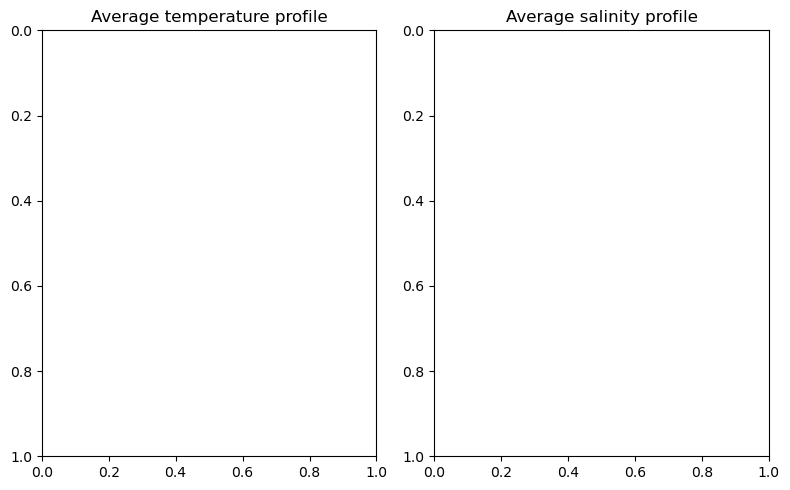

In [67]:
fig, ax = plt.subplots(1,2, figsize=(8,5))

for i, name in enumerate(['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross','amery','all']):
    ts_temp[name].plot(ax=ax[0], label=name, color=colors[i], linewidth=1.0)
    ts_salt[name].plot(ax=ax[1], label=name, color=colors[i], linewidth=1.0)

for axis in ax.ravel():
    axis.invert_yaxis()

ax[0].set_title('Average temperature profile')
ax[1].set_title('Average salinity profile')
ax[1].legend(frameon=False, loc=(1.0, 0.5))
fig.tight_layout()
# ax[1].plot(ts_amundsen_bwalt)

In [67]:
from matplotlib import colors as c

In [71]:
def setup_axes():

    fig, ax = plt.subplots(1,1, figsize=(8,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})
    
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.set_boundary(map_circle, transform=ax.transAxes)
            
    return fig, ax

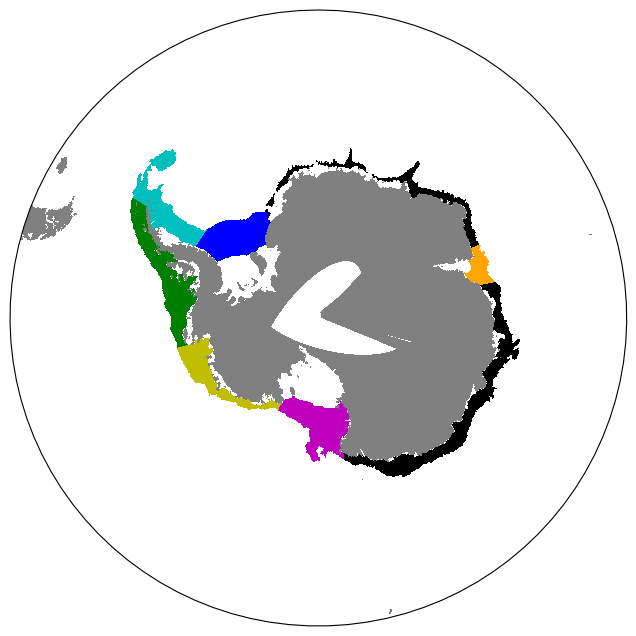

In [81]:
fig, ax = setup_axes()

plot_land = xr.where(nemo_mesh.top_level.isel(time_counter=0)==0, 1, np.nan)
cmap_land = c.ListedColormap(['gray'])

ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, plot_land,   transform=ccrs.PlateCarree(), cmap=cmap_land)
ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, masked_regions['all']               , transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['k']))
ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, masked_regions['amundsen_sea']      , transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['y']))
ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, masked_regions['bellingshausen_sea'], transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['g']))
ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, masked_regions['larsen']            , transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['c']))
ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, masked_regions['filchner_ronne']    , transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['b']))
ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, masked_regions['amery']             , transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['orange']))
ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, masked_regions['ross']              , transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['m']))

# masked_regions['bellingshausen_sea'][0].plot(ax=ax)